In [125]:
import networkx as nx
import matplotlib.pyplot as plt
from csv import DictReader
from itertools import groupby
import gtfs_kit as gk
import numpy as np
import pandas as pd
import os
import h3
from tqdm import tqdm
import contextily as cx
import numpy as np

In [169]:
def get_stop_id(stop_id):
    """ translate stop_id to parent_stop_id 
        if available
    """
    if STOPS[stop_id]['parent_station'] == '' or np.isnan(STOPS[stop_id]['parent_station']):
        return stop_id
    else:
        return STOPS[stop_id]['parent_station']


def add_stop_to_graph(G, stop_id):
    """ add stop as new node to graph
    """
    #lookup details of the stop (parent stop if available)
    node = STOPS[get_stop_id(stop_id)]

    if node['stop_id'] not in G.nodes:
        G.add_node(node['stop_id'], 
                   stop_name = node['stop_name'], 
                   stop_lon = node['stop_lon'], 
                   stop_lat = node['stop_lat'])
    return G

def add_edge_to_graph(G, from_id, to_id, route_short_name):
    """ add edge to graph 
        adding the route short name as a key
        if the edge and key exist, increment the count
    """
    edge = G.get_edge_data(get_stop_id(from_id), get_stop_id(to_id),route_short_name, default = 0)
    if edge == 0:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=1)
    else:
        G.add_edge(get_stop_id(from_id), get_stop_id(to_id), 
                   key=route_short_name,
                   count=edge['count']+1)
        
def get_stops_from_gtfs(path):
    feed = (gk.read_feed(path, dist_units='km'))
    return feed

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

In [144]:
DATA_ROOT='/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/mta_manhattan_gtfs.zip'
#DATA_ROOT='/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips/subway_gtfs/'
TRIPS_FILE = f'{DATA_ROOT}trips.txt'
ROUTES_FILE = f'{DATA_ROOT}routes.txt'
STOPS_FILE = f'{DATA_ROOT}stops.txt'

INCLUDE_AGENCIES=['MTA NYCT']
IGNORE_ROUTE=[]

In [145]:
# put all gtfs zips in one directory

# assign directory
directory = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips'
files = gk.list_feed(directory)
files=files[files['file_name'].str.contains('.zip')]['file_name']

In [147]:
files

1         mta_brooklyn_gtfs.zip
2            mta_bronx_gtfs.zip
3        mta_manhattan_gtfs.zip
4               subway_gtfs.zip
5           mta_queens_gtfs.zip
6                 nyc_ferry.zip
7      long_island_railroad.zip
8    mta_staten_island_gtfs.zip
9          metro_north_gtfs.zip
Name: file_name, dtype: object

In [148]:
feed = (gk.read_feed(DATA_ROOT, dist_units='km'))

In [149]:
STOPS = feed.get_stops().set_index('stop_id').to_dict('index')

for key in STOPS.keys():
    STOPS[key]['stop_id'] = key

In [150]:
ROUTES = feed.get_routes().set_index('route_id').to_dict('index')

for key in ROUTES.keys():
    ROUTES[key]['route_id'] = key

In [151]:
TRIPS = feed.get_trips().set_index('trip_id').to_dict('index')

for key in TRIPS.keys():
    TRIPS[key]['route_short_name'] = ROUTES[TRIPS[key]['route_id']]['route_short_name']
    TRIPS[key]['trip_id'] = key

In [152]:
stop_times = feed.get_stop_times()

In [153]:
# sort just to be sure
sorted_stops = feed.get_stop_times().sort_values(['trip_id', 'stop_sequence'], ascending=[True, True])

In [154]:
trip_ids = sorted_stops['trip_id'].to_numpy()
stops_ids = sorted_stops['stop_id'].to_numpy()

In [155]:
stops = set()
edges = dict()

next_trip = trip_ids[1]
for i in tqdm(range(len(stops_ids)-1)):
    if trip_ids[i] in TRIPS:
        trip = TRIPS[trip_ids[i]]
        # if we are still on the same route, create edges
        if trip_ids[i]==next_trip:
            stop = stops_ids[i]
            stops.add(stop)
            next_stop = stops_ids[i+1]
            edge = (stop, next_stop)
            edges[edge] = trip['route_short_name']
        # we start a new route
        else:
            stop = stops_ids[i]
            stops.add(stop)
        
        if i < len(stops_ids)-2:
            next_trip=trip_ids[i+2]
        else:
            next_trip = -1
        
# add the final stop to the list
stops.add(next_stop)

100%|███████████████████████████████| 939680/939680 [00:02<00:00, 435906.60it/s]


In [156]:
G = nx.MultiGraph()

In [170]:
print ('stops', len(stops))
print ('edges', len(edges))

for stop_id in STOPS:
    if stop_id in stops:
        add_stop_to_graph(G, stop_id)
        
print('Nodes:', G.number_of_nodes() )
        
for (start_stop_id, end_stop_id), route_short_name in edges.items():
    if start_stop_id==end_stop_id:
        print(start_stop_id, end_stop_id, route_short_name)
    add_edge_to_graph(G, 
                      from_id = start_stop_id, 
                      to_id = end_stop_id, 
                      route_short_name=route_short_name)
print('Edges:', G.number_of_edges() )



deg = nx.degree(G)
labels = {stop_id: G.nodes[stop_id]['stop_name'] if deg[stop_id] >= 0 else ''
          for stop_id in G.nodes}

pos = {stop_id: (G.nodes[stop_id]['stop_lon'], G.nodes[stop_id]['stop_lat'])
       for stop_id in G.nodes}

stops 1808
edges 2015
Nodes: 1808
Edges: 2015


# Scaling Required

min/max scale each disconnected component, then scale by the number of nodes in each component by multiplying by num nodes in component/total num nodes

In [171]:
G_simple = nx.Graph(G)

In [172]:
btw = nx.betweenness_centrality(G_simple)

In [173]:
l=np.zeros(len(btw))
keys=list(btw.keys())

for i in range(len(btw)):
    l[i]=btw[keys[i]]

In [174]:
scale = (9/np.max(l))

for key in btw.keys():
    btw[key] = (btw[key]*(9/np.max(l)))+1

In [175]:
nx.set_node_attributes(G_simple, btw, "betweenness")

In [322]:
#nx.write_graphml(G,'g.xml')
#nx.write_graphml(G_simple,'g_simple_fast.xml')

In [193]:
df_btw = pd.DataFrame.from_dict(btw, orient='index')
df_btw.columns=['betweenness']

In [194]:
betweenness_geo = df_btw.join(pd.DataFrame.from_dict(pos, orient='index'))
betweenness_geo.columns = ['betweenness','lon','lat']

In [195]:
betweenness_geo

,betweenness,lon,lat
400001,1.275477,-73.990292,40.731342
400002,1.000086,-73.989958,40.732608
400003,1.025017,-73.989720,40.733936
400007,1.024974,-73.987053,40.738976
400026,1.000014,-73.969329,40.766274
...,...,...,...
904242,1.150448,-73.871153,40.772722
904245,1.100356,-73.867345,40.771079
904246,1.100356,-73.875891,40.772187
904918,1.000000,-73.944774,40.779873


In [183]:
APERTURE_SIZE = 10
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
betweenness_geo[hex_col] = betweenness_geo.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,APERTURE_SIZE),1)
hex_df = pd.DataFrame(betweenness_geo.groupby([hex_col])['betweenness'].agg('sum')).reset_index()

#find center of hex for visualization
hex_df['lat'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
hex_df['lon'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [184]:
hex_df

,hex10,betweenness,lat,lon
0,8a2a1008800ffff,2.841394,40.796699,-73.974402
1,8a2a10088027fff,2.812837,40.798611,-73.973559
2,8a2a10088047fff,3.671054,40.795238,-73.972509
3,8a2a1008806ffff,3.734047,40.794902,-73.970966
4,8a2a10088077fff,1.050206,40.796362,-73.972859
...,...,...,...,...
1250,8a2a1072dd57fff,1.188439,40.713294,-73.985821
1251,8a2a1072dd8ffff,1.489285,40.714301,-73.990443
1252,8a2a1072dd97fff,1.796773,40.715760,-73.992333
1253,8a2a1072dd9ffff,1.537750,40.714637,-73.991984


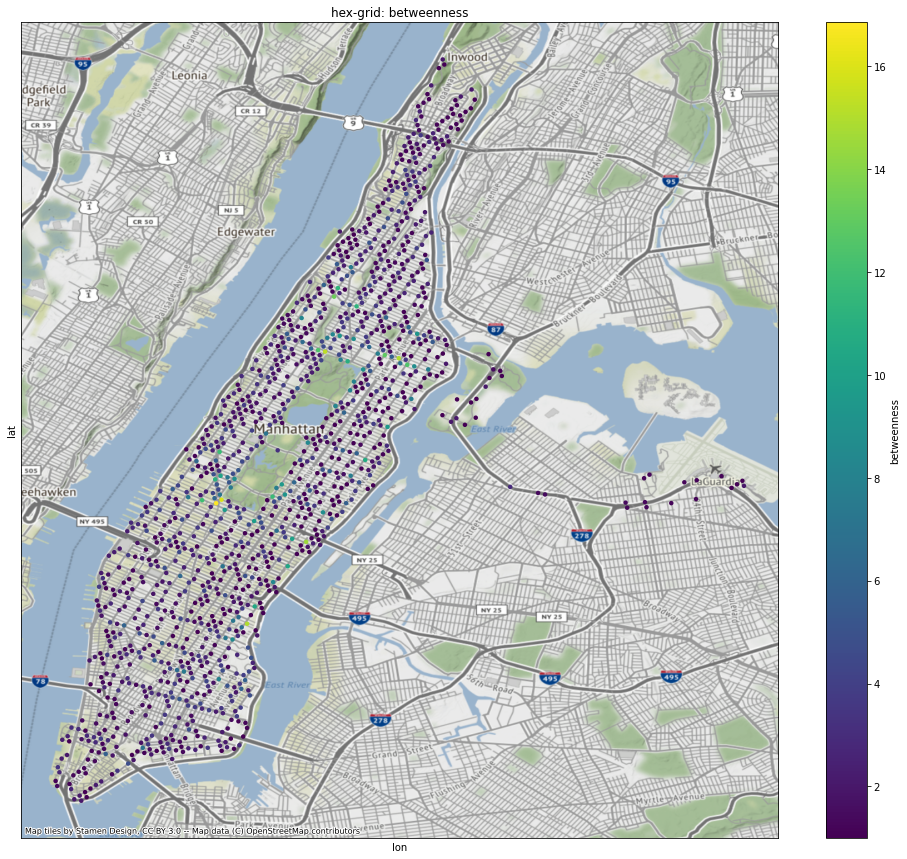

In [185]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
hex_df.plot.scatter(ax=ax, x='lon', y='lat', c='betweenness',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])

plt.title('hex-grid: betweenness');

cx.add_basemap(ax=ax, crs="EPSG:4326")


In [186]:
stops_kring

,hex9,betweenness,lat,lon
0,892a10081a7ffff,0.105263,40.829886,-73.963139
1,892a10081b7ffff,0.105263,40.832587,-73.961100
2,892a10085a7ffff,0.361234,40.848794,-73.948859
3,892a10085b7ffff,0.726757,40.851496,-73.946818
4,892a1008803ffff,3.616822,40.797823,-73.974752
...,...,...,...,...
894,892a1072ea3ffff,0.695262,40.719890,-74.020913
895,892a1072ea7ffff,1.266640,40.717308,-74.018671
896,892a1072eafffff,0.617506,40.717191,-74.022944
897,892a1072eb3ffff,0.392064,40.722588,-74.018881


sum sanity check: 1.0


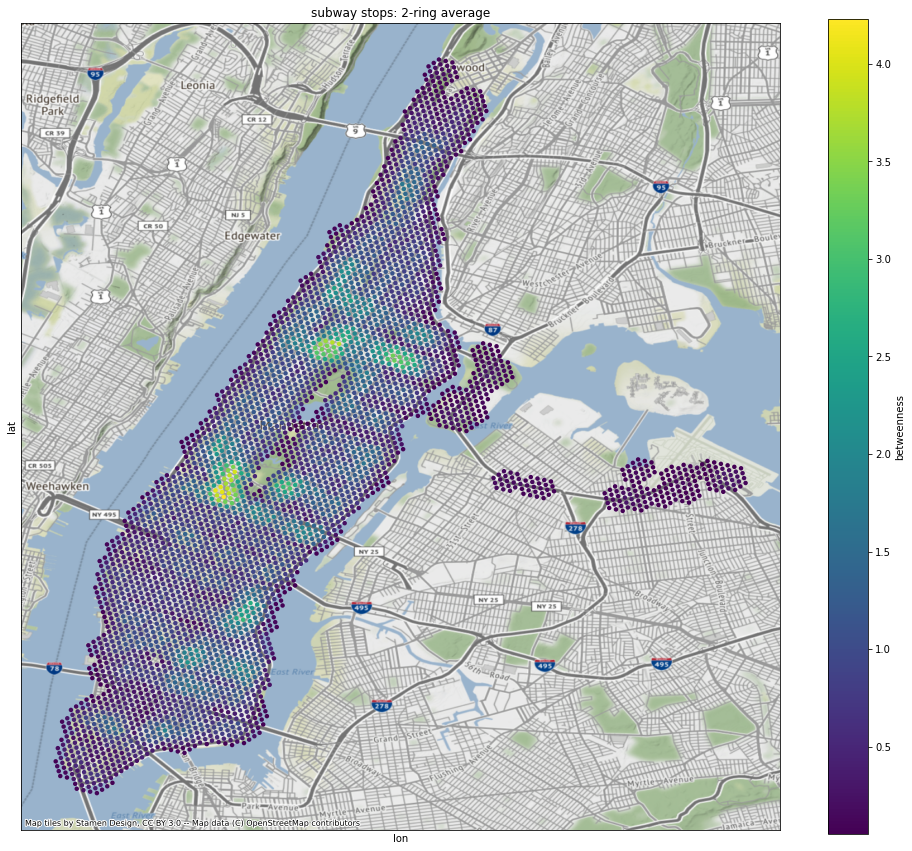

In [187]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(hex_df, hex_col, metric_col='betweenness', k=k)
print('sum sanity check:', stops_kring['betweenness'].sum() / hex_df['betweenness'].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='lon', y='lat', c='betweenness',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

cx.add_basemap(ax=ax, crs="EPSG:4326")

In [ ]:
#